In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import itertools
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Mengimpor data penjualan
data = "https://raw.githubusercontent.com/indescared/otwsarjana/main/data%20penjualan.xlsx"
df = pd.read_excel(data)
df['tanggal'] = pd.to_datetime(df['tanggal'])
df = df.sort_values(by='tanggal')

In [ ]:
# Split data
train_size = int(len(df) * 0.8)
y_train = df.iloc[:train_size]['volume penjualan']
y_test = df.iloc[train_size:]['volume penjualan']

In [ ]:
# Manual SARIMA order (user-defined optimal order)
sarima_order = (1, 0, 0)  # Example order, replace with the best found order
seasonal_order = (1, 0, 1, 7)
sarima_model = SARIMAX(y_train, order=sarima_order, seasonal_order=seasonal_order).fit()
sarima_train_predictions = sarima_model.fittedvalues
sarima_test_predictions = sarima_model.forecast(steps=len(y_test))

In [ ]:
# Calculate residuals and normalize data
residuals = y_train - sarima_train_predictions
scaler = MinMaxScaler()
residuals_scaled = scaler.fit_transform(residuals.values.reshape(-1, 1))
print("Residuals (Top 3):")
print(residuals.head(3))
print("\nResiduals (Bottom 3):")
print(residuals.tail(3))

Residuals (Top 3):
0    2.000000
1    0.507972
2    9.753119
dtype: float64

Residuals (Bottom 3):
1096    -1.535330
1097   -23.405226
1098    11.008466
dtype: float64


In [ ]:
# Prepare data for LSTM
def create_sequences(data, sequence_length):
    sequences, labels = [], []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(data[i + sequence_length])
    return np.array(sequences), np.array(labels)
seq_length = 30
X_train, y_train_lstm = create_sequences(residuals_scaled, seq_length)
X_test, y_test_lstm = create_sequences(scaler.transform(y_test.values.reshape(-1, 1)), seq_length)

In [ ]:
# Define the parameter grid for Grid Search
param_grid = {
    'units': [32, 64],
    'epochs': [20, 50],
    'batch_size': [16, 32],
    'dropout': [0.2, 0.3],
    'learning_rate': [0.001, 0.01]
}

best_mape = float('inf')
best_params = {}

for params in ParameterGrid(param_grid):
    # Build LSTM model with current parameters
    model = Sequential([
        LSTM(units=params['units'], activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
        Dropout(params['dropout']),
        LSTM(units=params['units'], activation='relu'),
        Dropout(params['dropout']),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss='mean_absolute_percentage_error')

    # Early Stopping Callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model with validation split
    history = model.fit(
        X_train, y_train_lstm,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        validation_split=0.2,
        verbose=0,
        callbacks=[early_stopping]
    )

    # Predictions on training set
    y_train_pred = model.predict(X_train)
    train_mape = mean_absolute_percentage_error(y_train_lstm, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train_lstm, y_train_pred))
    train_mae = mean_absolute_error(y_train_lstm, y_train_pred)

    # Predictions on test set
    y_test_pred = model.predict(X_test)
    if np.isnan(y_test_pred).any():
        print(f"Parameters: {params}, Skipping due to NaN in predictions")
        continue

    test_mape = mean_absolute_percentage_error(y_test_lstm, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test_lstm, y_test_pred))
    test_mae = mean_absolute_error(y_test_lstm, y_test_pred)

    print(f"Parameters: {params}, Train MAPE: {train_mape:.4f}, Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}, "
          f"Test MAPE: {test_mape:.4f}, Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}")

    # Update best parameters if current model is better
    if test_mape < best_mape:
        best_mape = test_mape
        best_params = params
        best_model = model
        best_history = history  # Save history for best model
        best_metrics = {
            "train_mape": train_mape,
            "train_rmse": train_rmse,
            "train_mae": train_mae,
            "test_mape": test_mape,
            "test_rmse": test_rmse,
            "test_mae": test_mae
        }

print(f"\nBest parameters: {best_params}")
print(f"Best Model Metrics:")
print(f"Train MAPE: {best_metrics['train_mape']:.4f}, Train RMSE: {best_metrics['train_rmse']:.4f}, Train MAE: {best_metrics['train_mae']:.4f}")
print(f"Test MAPE: {best_metrics['test_mape']:.4f}, Test RMSE: {best_metrics['test_rmse']:.4f}, Test MAE: {best_metrics['test_mae']:.4f}")



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Parameters: {'batch_size': 16, 'dropout': 0.2, 'epochs': 20, 'learning_rate': 0.001, 'units': 32}, Train MAPE: 664456978470.8157, Train RMSE: 0.1859, Train MAE: 0.1590, Test MAPE: 0.5762, Test RMSE: 0.2843, Test MAE: 0.2607


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Parameters: {'batch_size': 16, 'dropout': 0.2, 'epochs': 20, 'learning_rate': 0.001, 'units': 64}, Train MAPE: 522964875611.3691, Train RMSE: 0.2181, Train MAE: 0.1939, Test MAPE: 0.6705, Test RMSE: 0.3203, Test MAE: 0.2997


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Parameters: {'batch_size': 16, 'dropout': 0.2, 'epochs': 20, 'learning_rate': 0.01, 'units': 32}, Train MAPE: 579805832310.3595, Train RMSE: 0.1980, Train MAE: 0.1719, Test MAPE: 0.6639, Test RMSE: 0.3177, Test MAE: 0.2968


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Parameters: {'batch_size': 16, 'dropout': 0.2, 'epochs': 20, 'learning_rate': 0.01, 'units': 64}, Train MAPE: 1147885756040.8149, Train RMSE: 0.1115, Train MAE: 0.0803, Test MAPE: 0.3255, Test RMSE: 0.1937, Test MAE: 0.1573


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Parameters: {'batch_size': 16, 'dropout': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'units': 32}, Train MAPE: 659239123046.0389, Train RMSE: 0.1869, Train MAE: 0.1598, Test MAPE: 0.5803, Test RMSE: 0.2859, Test MAE: 0.2624


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Parameters: {'batch_size': 16, 'dropout': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'units': 64}, Train MAPE: 1170745834983.8879, Train RMSE: 0.1086, Train MAE: 0.0778, Test MAPE: 0.2442, Test RMSE: 0.1647, Test MAE: 0.1224


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Parameters: {'batch_size': 16, 'dropout': 0.2, 'epochs': 50, 'learning_rate': 0.01, 'units': 32}, Train MAPE: 398319106487.3845, Train RMSE: 0.2347, Train MAE: 0.2117, Test MAPE: 0.7710, Test RMSE: 0.3593, Test MAE: 0.3410


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Parameters: {'batch_size': 16, 'dropout': 0.2, 'epochs': 50, 'learning_rate': 0.01, 'units': 64}, Train MAPE: 806639317026.8832, Train RMSE: 0.1540, Train MAE: 0.1240, Test MAPE: 0.5359, Test RMSE: 0.2690, Test MAE: 0.2440


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Parameters: {'batch_size': 16, 'dropout': 0.3, 'epochs': 20, 'learning_rate': 0.001, 'units': 32}, Train MAPE: 775529618881.7097, Train RMSE: 0.1704, Train MAE: 0.1422, Test MAPE: 0.5046, Test RMSE: 0.2575, Test MAE: 0.2313


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Parameters: {'batch_size': 16, 'dropout': 0.3, 'epochs': 20, 'learning_rate': 0.001, 'units': 64}, Train MAPE: 1016868223139.1747, Train RMSE: 0.1262, Train MAE: 0.0943, Test MAPE: 0.3496, Test RMSE: 0.2021, Test MAE: 0.1672


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Parameters: {'batch_size': 16, 'dropout': 0.3, 'epochs': 20, 'learning_rate': 0.01, 'units': 32}, Train MAPE: 1250020927087.9214, Train RMSE: 0.1047, Train MAE: 0.0754, Test MAPE: 0.2710, Test RMSE: 0.1753, Test MAE: 0.1346


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Parameters: {'batch_size': 16, 'dropout': 0.3, 'epochs': 20, 'learning_rate': 0.01, 'units': 64}, Train MAPE: 1264628059635.3989, Train RMSE: 0.1040, Train MAE: 0.0752, Test MAPE: 0.2666, Test RMSE: 0.1738, Test MAE: 0.1327


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Parameters: {'batch_size': 16, 'dropout': 0.3, 'epochs': 50, 'learning_rate': 0.001, 'units': 32}, Train MAPE: 712169246348.8103, Train RMSE: 0.1789, Train MAE: 0.1514, Test MAPE: 0.5555, Test RMSE: 0.2765, Test MAE: 0.2522


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Parameters: {'batch_size': 16, 'dropout': 0.3, 'epochs': 50, 'learning_rate': 0.001, 'units': 64}, Train MAPE: 606845933432.5316, Train RMSE: 0.2021, Train MAE: 0.1767, Test MAPE: 0.6132, Test RMSE: 0.2983, Test MAE: 0.2761


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Parameters: {'batch_size': 16, 'dropout': 0.3, 'epochs': 50, 'learning_rate': 0.01, 'units': 32}, Train MAPE: 1119523503576.5574, Train RMSE: 0.1107, Train MAE: 0.0794, Test MAPE: 0.3556, Test RMSE: 0.2040, Test MAE: 0.1697


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Parameters: {'batch_size': 16, 'dropout': 0.3, 'epochs': 50, 'learning_rate': 0.01, 'units': 64}, Train MAPE: 1001596781893.0668, Train RMSE: 0.1289, Train MAE: 0.0972, Test MAPE: 0.4012, Test RMSE: 0.2198, Test MAE: 0.1885


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Parameters: {'batch_size': 32, 'dropout': 0.2, 'epochs': 20, 'learning_rate': 0.001, 'units': 32}, Train MAPE: 1061697132622.8765, Train RMSE: 0.1230, Train MAE: 0.0914, Test MAPE: 0.3189, Test RMSE: 0.1920, Test MAE: 0.1547


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Parameters: {'batch_size': 32, 'dropout': 0.2, 'epochs': 20, 'learning_rate': 0.001, 'units': 64}, Train MAPE: 946481759710.3616, Train RMSE: 0.1412, Train MAE: 0.1102, Test MAPE: 0.4039, Test RMSE: 0.2211, Test MAE: 0.1898


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Parameters: {'batch_size': 32, 'dropout': 0.2, 'epochs': 20, 'learning_rate': 0.01, 'units': 32}, Train MAPE: 521376862679.8679, Train RMSE: 0.2102, Train MAE: 0.1852, Test MAPE: 0.6978, Test RMSE: 0.3308, Test MAE: 0.3108


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Parameters: {'batch_size': 32, 'dropout': 0.2, 'epochs': 20, 'learning_rate': 0.01, 'units': 64}, Train MAPE: 838582257409.5918, Train RMSE: 0.1520, Train MAE: 0.1220, Test MAPE: 0.5018, Test RMSE: 0.2563, Test MAE: 0.2300


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Parameters: {'batch_size': 32, 'dropout': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'units': 32}, Train MAPE: 104131840236.5386, Train RMSE: 0.2962, Train MAE: 0.2775, Test MAPE: 0.9436, Test RMSE: 0.4275, Test MAE: 0.4122


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Parameters: {'batch_size': 32, 'dropout': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'units': 64}, Train MAPE: 498707375421.6631, Train RMSE: 0.2157, Train MAE: 0.1910, Test MAPE: 0.6890, Test RMSE: 0.3274, Test MAE: 0.3072


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Parameters: {'batch_size': 32, 'dropout': 0.2, 'epochs': 50, 'learning_rate': 0.01, 'units': 64}, Train MAPE: 1157036668002.9829, Train RMSE: 0.1134, Train MAE: 0.0824, Test MAPE: 0.2484, Test RMSE: 0.1654, Test MAE: 0.1241


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Parameters: {'batch_size': 32, 'dropout': 0.3, 'epochs': 20, 'learning_rate': 0.001, 'units': 32}, Train MAPE: 1039805957521.6945, Train RMSE: 0.1255, Train MAE: 0.0939, Test MAPE: 0.3366, Test RMSE: 0.1978, Test MAE: 0.1620


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Parameters: {'batch_size': 32, 'dropout': 0.3, 'epochs': 20, 'learning_rate': 0.001, 'units': 64}, Train MAPE: 350682610731.8198, Train RMSE: 0.2484, Train MAE: 0.2264, Test MAPE: 0.7863, Test RMSE: 0.3654, Test MAE: 0.3474


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Parameters: {'batch_size': 32, 'dropout': 0.3, 'epochs': 20, 'learning_rate': 0.01, 'units': 32}, Train MAPE: 876996463487.0640, Train RMSE: 0.1471, Train MAE: 0.1166, Test MAPE: 0.4855, Test RMSE: 0.2503, Test MAE: 0.2233


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Parameters: {'batch_size': 32, 'dropout': 0.3, 'epochs': 20, 'learning_rate': 0.01, 'units': 64}, Train MAPE: 977629124196.4399, Train RMSE: 0.1303, Train MAE: 0.0985, Test MAPE: 0.3681, Test RMSE: 0.2083, Test MAE: 0.1749


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Parameters: {'batch_size': 32, 'dropout': 0.3, 'epochs': 50, 'learning_rate': 0.001, 'units': 32}, Train MAPE: 541772056275.7686, Train RMSE: 0.2024, Train MAE: 0.1766, Test MAPE: 0.7048, Test RMSE: 0.3335, Test MAE: 0.3137


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Parameters: {'batch_size': 32, 'dropout': 0.3, 'epochs': 50, 'learning_rate': 0.001, 'units': 64}, Train MAPE: 858355014722.4972, Train RMSE: 0.1539, Train MAE: 0.1240, Test MAPE: 0.4404, Test RMSE: 0.2341, Test MAE: 0.2048


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Parameters: {'batch_size': 32, 'dropout': 0.3, 'epochs': 50, 'learning_rate': 0.01, 'units': 32}, Train MAPE: 292661159521.0178, Train RMSE: 0.2577, Train MAE: 0.2365, Test MAPE: 0.8316, Test RMSE: 0.3831, Test MAE: 0.3660


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Parameters: {'batch_size': 32, 'dropout': 0.3, 'epochs': 50, 'learning_rate': 0.01, 'units': 64}, Train MAPE: 626605319194.3707, Train RMSE: 0.1890, Train MAE: 0.1621, Test MAPE: 0.6394, Test RMSE: 0.3082, Test MAE: 0.2867

Best parameters: {'batch_size': 16, 'dropout': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'units': 64}
Best Model Metrics:
Train MAPE: 1170745834983.8879, Train RMSE: 0.1086, Train MAE: 0.0778
Test MAPE: 0.2442, Test RMSE: 0.1647, Test MAE: 0.1224


In [ ]:
# Optimized LSTM hyperparameters (user-defined)
epochs = 50
batch_size = 16
units = 32
dropout_rate = 0.2
learning_rate = 0.001

# Build optimized LSTM model
model = Sequential([
    LSTM(units, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(dropout_rate),
    LSTM(units, activation='relu'),
    Dropout(dropout_rate),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
model.fit(X_train, y_train_lstm, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test_lstm), verbose=1)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0450 - val_loss: 0.0210
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0128 - val_loss: 0.0257
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0127 - val_loss: 0.0193
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0137 - val_loss: 0.0251
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0119 - val_loss: 0.0204
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0134 - val_loss: 0.0232
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0112 - val_loss: 0.0199
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0123 - val_loss: 0.0260
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0123 - val_loss: 0.0228
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0128 - val_loss: 0.0257
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0114 - val_loss: 0.0235
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0108 - val_l

In [ ]:
# Predict residuals with LSTM
train_residual_predictions = model.predict(X_train)
test_residual_predictions = model.predict(X_test)

# --- Tampilan Sebelum Denormalisasi ---
print("--- Prediksi Residual (Sebelum Denormalisasi) ---")

print("\nTrain Residual Predictions (5 Teratas):")
# print(train_residual_predictions[:5]) # Ini akan mencetak 5 baris pertama dari array
for i in range(5):
    print(f"Data ke-{i+1}: {train_residual_predictions[i]}")

print("\nTrain Residual Predictions (5 Terbawah):")
# print(train_residual_predictions[-5:]) # Ini akan mencetak 5 baris terakhir dari array
for i in range(1, 6): # Menggunakan 1 sampai 5 untuk mencetak data terakhir
    print(f"Data ke-{len(train_residual_predictions)-5+i}: {train_residual_predictions[-5+i]}")


print("\nTest Residual Predictions (5 Teratas):")
# print(test_residual_predictions[:5])
for i in range(5):
    print(f"Data ke-{i+1}: {test_residual_predictions[i]}")

print("\nTest Residual Predictions (5 Terbawah):")
# print(test_residual_predictions[-5:])
for i in range(1, 6):
    print(f"Data ke-{len(test_residual_predictions)-5+i}: {test_residual_predictions[-5+i]}")

print("-" * 50)


train_residual_predictions_denorm = scaler.inverse_transform(train_residual_predictions)
test_residual_predictions_denorm = scaler.inverse_transform(test_residual_predictions)

# --- Tampilan Setelah Denormalisasi ---
print("\n--- Prediksi Residual (Setelah Denormalisasi) ---")

print("\nTrain Residual Predictions (5 Teratas):")
# print(train_residual_predictions_denorm[:5])
for i in range(5):
    print(f"Data ke-{i+1}: {train_residual_predictions_denorm[i]}")

print("\nTrain Residual Predictions (5 Terbawah):")
# print(train_residual_predictions_denorm[-5:])
for i in range(1, 6):
    print(f"Data ke-{len(train_residual_predictions_denorm)-5+i}: {train_residual_predictions_denorm[-5+i]}")


print("\nTest Residual Predictions (5 Teratas):")
# print(test_residual_predictions_denorm[:5])
for i in range(5):
    print(f"Data ke-{i+1}: {test_residual_predictions_denorm[i]}")

print("\nTest Residual Predictions (5 Terbawah):")
# print(test_residual_predictions_denorm[-5:])
for i in range(1, 6):
    print(f"Data ke-{len(test_residual_predictions_denorm)-5+i}: {test_residual_predictions_denorm[-5+i]}")
print("-" * 50)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
--- Prediksi Residual (Sebelum Denormalisasi) ---

Train Residual Predictions (5 Teratas):
Data ke-1: [0.31448102]
Data ke-2: [0.31170908]
Data ke-3: [0.30932692]
Data ke-4: [0.30916148]
Data ke-5: [0.30964154]

Train Residual Predictions (5 Terbawah):
Data ke-1065: [0.32960206]
Data ke-1066: [0.33106354]
Data ke-1067: [0.3324071]
Data ke-1068: [0.33223093]
Data ke-1069: [0.31448102]

Test Residual Predictions (5 Teratas):
Data ke-1: [0.30500028]
Data ke-2: [0.2928893]
Data ke-3: [0.28678033]
Data ke-4: [0.27520642]
Data ke-5: [0.26735523]

Test Residual Predictions (5 Terbawah):
Data ke-241: [0.28746596]
Data ke-242: [0.28783914]
Data ke-243: [0.28503802]
Data ke-244: [0.27878794]
Data ke-245: [0.30500028]
--------------------------------------------------

--- Prediksi Residual (Setelah Denormalisasi) ---

Train Residual Predictions (5 Teratas):
Data ke-1: [7.6864295]
Data ke-2: [6.576698]
Data ke-3: [5.623

In [ ]:
# Combine SARIMA and LSTM results
combined_predictions = sarima_test_predictions.values[:len(test_residual_predictions)] + test_residual_predictions.flatten()

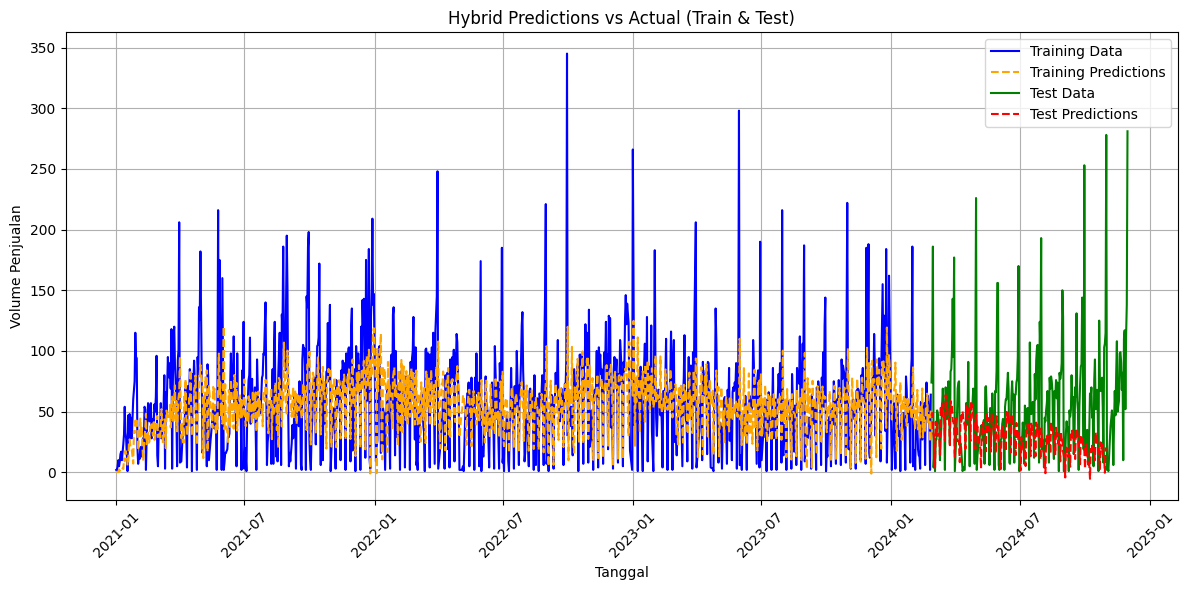

In [ ]:
# Plot training data
plt.figure(figsize=(12, 6))
plt.plot(df['tanggal'][:train_size], y_train, label='Training Data', color='blue')

# Plot predictions on training data
plt.plot(df['tanggal'][:train_size], sarima_train_predictions, label='Training Predictions', color='orange', linestyle='--')


# Plot test data
plt.plot(df['tanggal'][train_size:], y_test, label='Test Data', color='green')

# Plot predictions on test data
plt.plot(df['tanggal'][train_size:train_size + len(combined_predictions)], combined_predictions, label='Test Predictions', color='red', linestyle='--')

plt.title('Hybrid Predictions vs Actual (Train & Test)')
plt.xlabel('Tanggal')
plt.ylabel('Volume Penjualan')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.grid(True)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()


In [ ]:
# Evaluate Model
mape_train = mean_absolute_percentage_error(y_train[seq_length:], sarima_train_predictions[seq_length:] + train_residual_predictions.flatten())
rmse_train = mean_squared_error(y_train[seq_length:], sarima_train_predictions[seq_length:] + train_residual_predictions.flatten()) ** 0.5
mae_train = mean_absolute_error(y_train[seq_length:], sarima_train_predictions[seq_length:] + train_residual_predictions.flatten())

print(f"Train MAPE: {mape_train}, Train RMSE: {rmse_train}, Train MAE: {mae_train}")

mape_test = mean_absolute_percentage_error(y_test[:len(combined_predictions)], combined_predictions)
rmse_test = mean_squared_error(y_test[:len(combined_predictions)], combined_predictions) ** 0.5
mae_test = mean_absolute_error(y_test[:len(combined_predictions)], combined_predictions)

print(f"Test MAPE: {mape_test}, Test RMSE: {rmse_test}, Test MAE: {mae_test}")


Train MAPE: 2.708957375732916, Train RMSE: 40.570516275282614, Train MAE: 29.00771282331047
Test MAPE: 1.9360763603074056, Test RMSE: 47.58004186630629, Test MAE: 33.818218043053825


In [ ]:
# Forecast next 30 days
future_steps = 30
sarima_forecast = sarima_model.forecast(steps=future_steps)
residuals_forecast = model.predict(np.array([residuals_scaled[-seq_length:]]))
hybrid_forecast = sarima_forecast.values + scaler.inverse_transform(residuals_forecast).flatten()
forecast_dates_hybrid = pd.date_range(start=df['tanggal'].iloc[-1] + pd.Timedelta(days=1), periods=future_steps)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


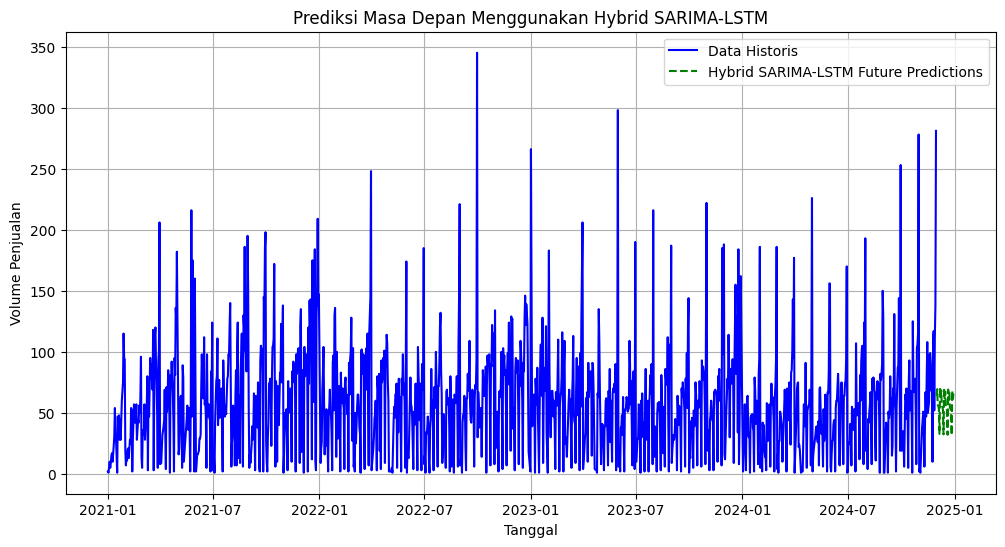

,tanggal,volume penjualan
0,2024-12-01,63.991052
1,2024-12-02,69.480507
2,2024-12-03,56.324743
3,2024-12-04,55.783130
4,2024-12-05,53.226690
5,2024-12-06,32.748079
6,2024-12-07,70.961202
7,2024-12-08,62.105033
8,2024-12-09,68.305716
9,2024-12-10,55.556741


In [ ]:
# Visualize future predictions
plt.figure(figsize=(12, 6))
plt.plot(df['tanggal'], df['volume penjualan'], label='Data Historis', color='blue')
plt.plot(forecast_dates_hybrid, hybrid_forecast, label='Hybrid SARIMA-LSTM Future Predictions', color='green', linestyle='--')
plt.title('Prediksi Masa Depan Menggunakan Hybrid SARIMA-LSTM')
plt.xlabel('Tanggal')
plt.ylabel('Volume Penjualan')
plt.legend()
plt.grid(True)
plt.show()

# Create a DataFrame for the future forecast
forecast_df = pd.DataFrame({'tanggal': forecast_dates_hybrid, 'volume penjualan': hybrid_forecast})
forecast_df